# Experiment 1: CNN using EfficientNetB3

The purpose of this first experiment is just to give us a better insight of the dataset, the behavior of parameters and also to consider and evaluate the computational resources.

For this first experimento we are going to evaluate using some EfficienNet model, fine-tuning using multiple dense layers and to try a decent fit for the 256x256 dataset.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import tensorflow_addons as tfa
import sklearn
import matplotlib

In [2]:
# Data preparation
def read_and_decode(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def decode_csv(csv_row):
    record_defaults = ["filepaths", "labels"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename)
    return img, label_string

dataset = (tf.data.TextLineDataset(
    "new_train.csv").
    map(decode_csv))

In [3]:
for img, label in dataset.take(5):
    avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    print(label, avg)

tf.Tensor(b'1', shape=(), dtype=string) tf.Tensor([0.25426534 0.25426534 0.25426534], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.08893454 0.08893454 0.08893454], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.0688068 0.0688068 0.0688068], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.19782998 0.19782998 0.19782998], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.06690245 0.06690245 0.06690245], shape=(3,), dtype=float32)


In [4]:
def plot_images(filename):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(35,15))
    dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        ax[idx//5, idx%5].axis('off')

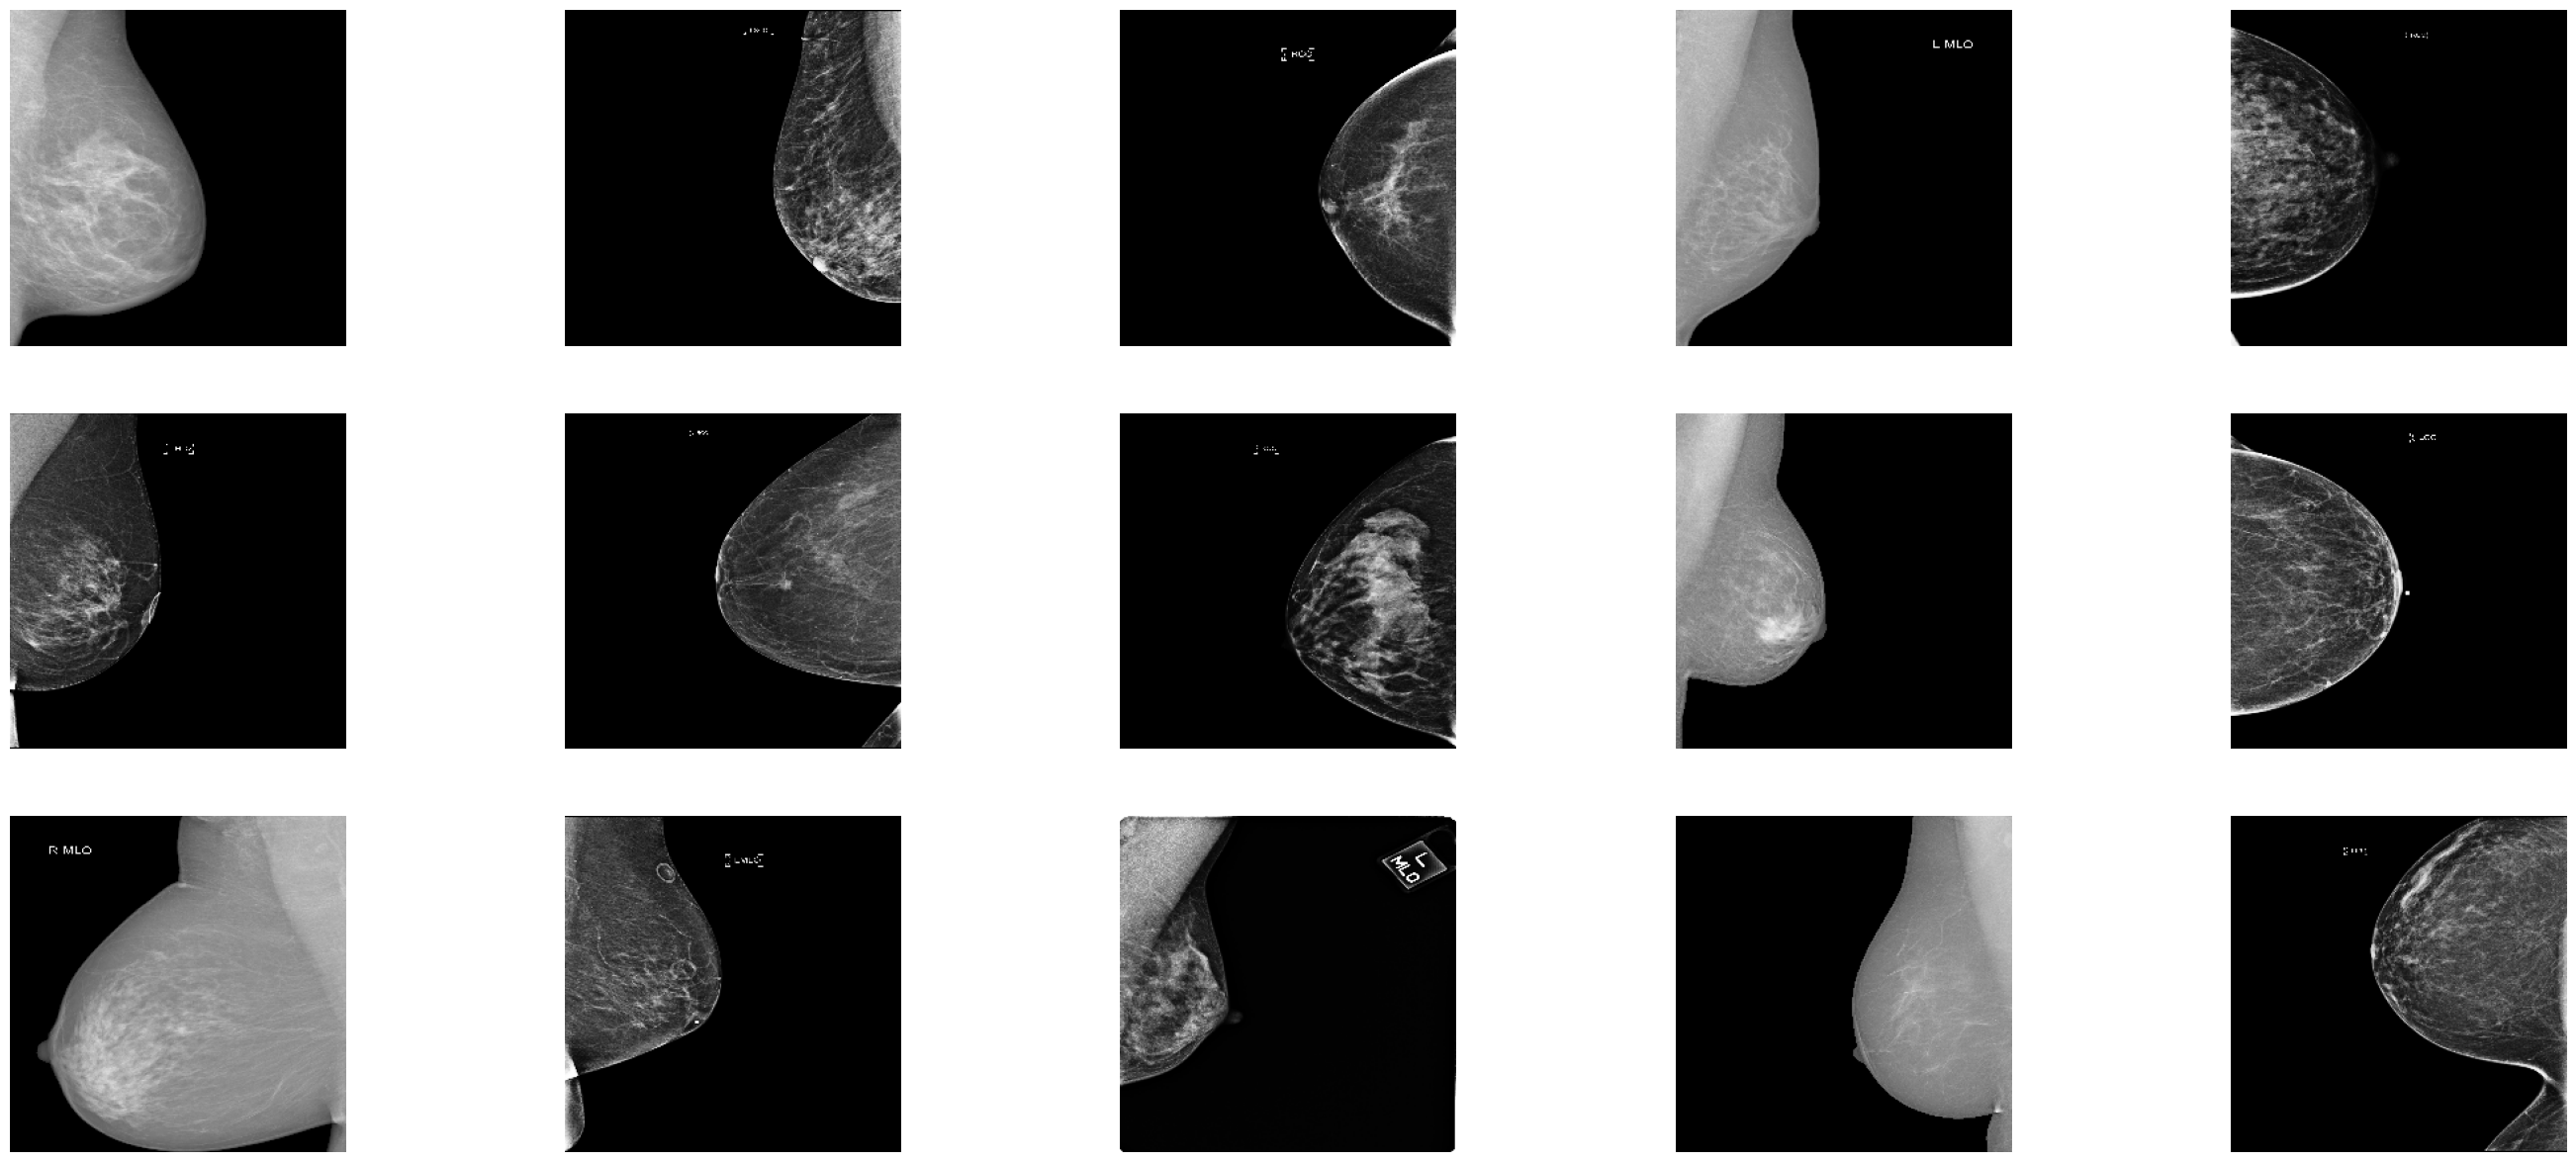

In [5]:
plot_images("new_train.csv")

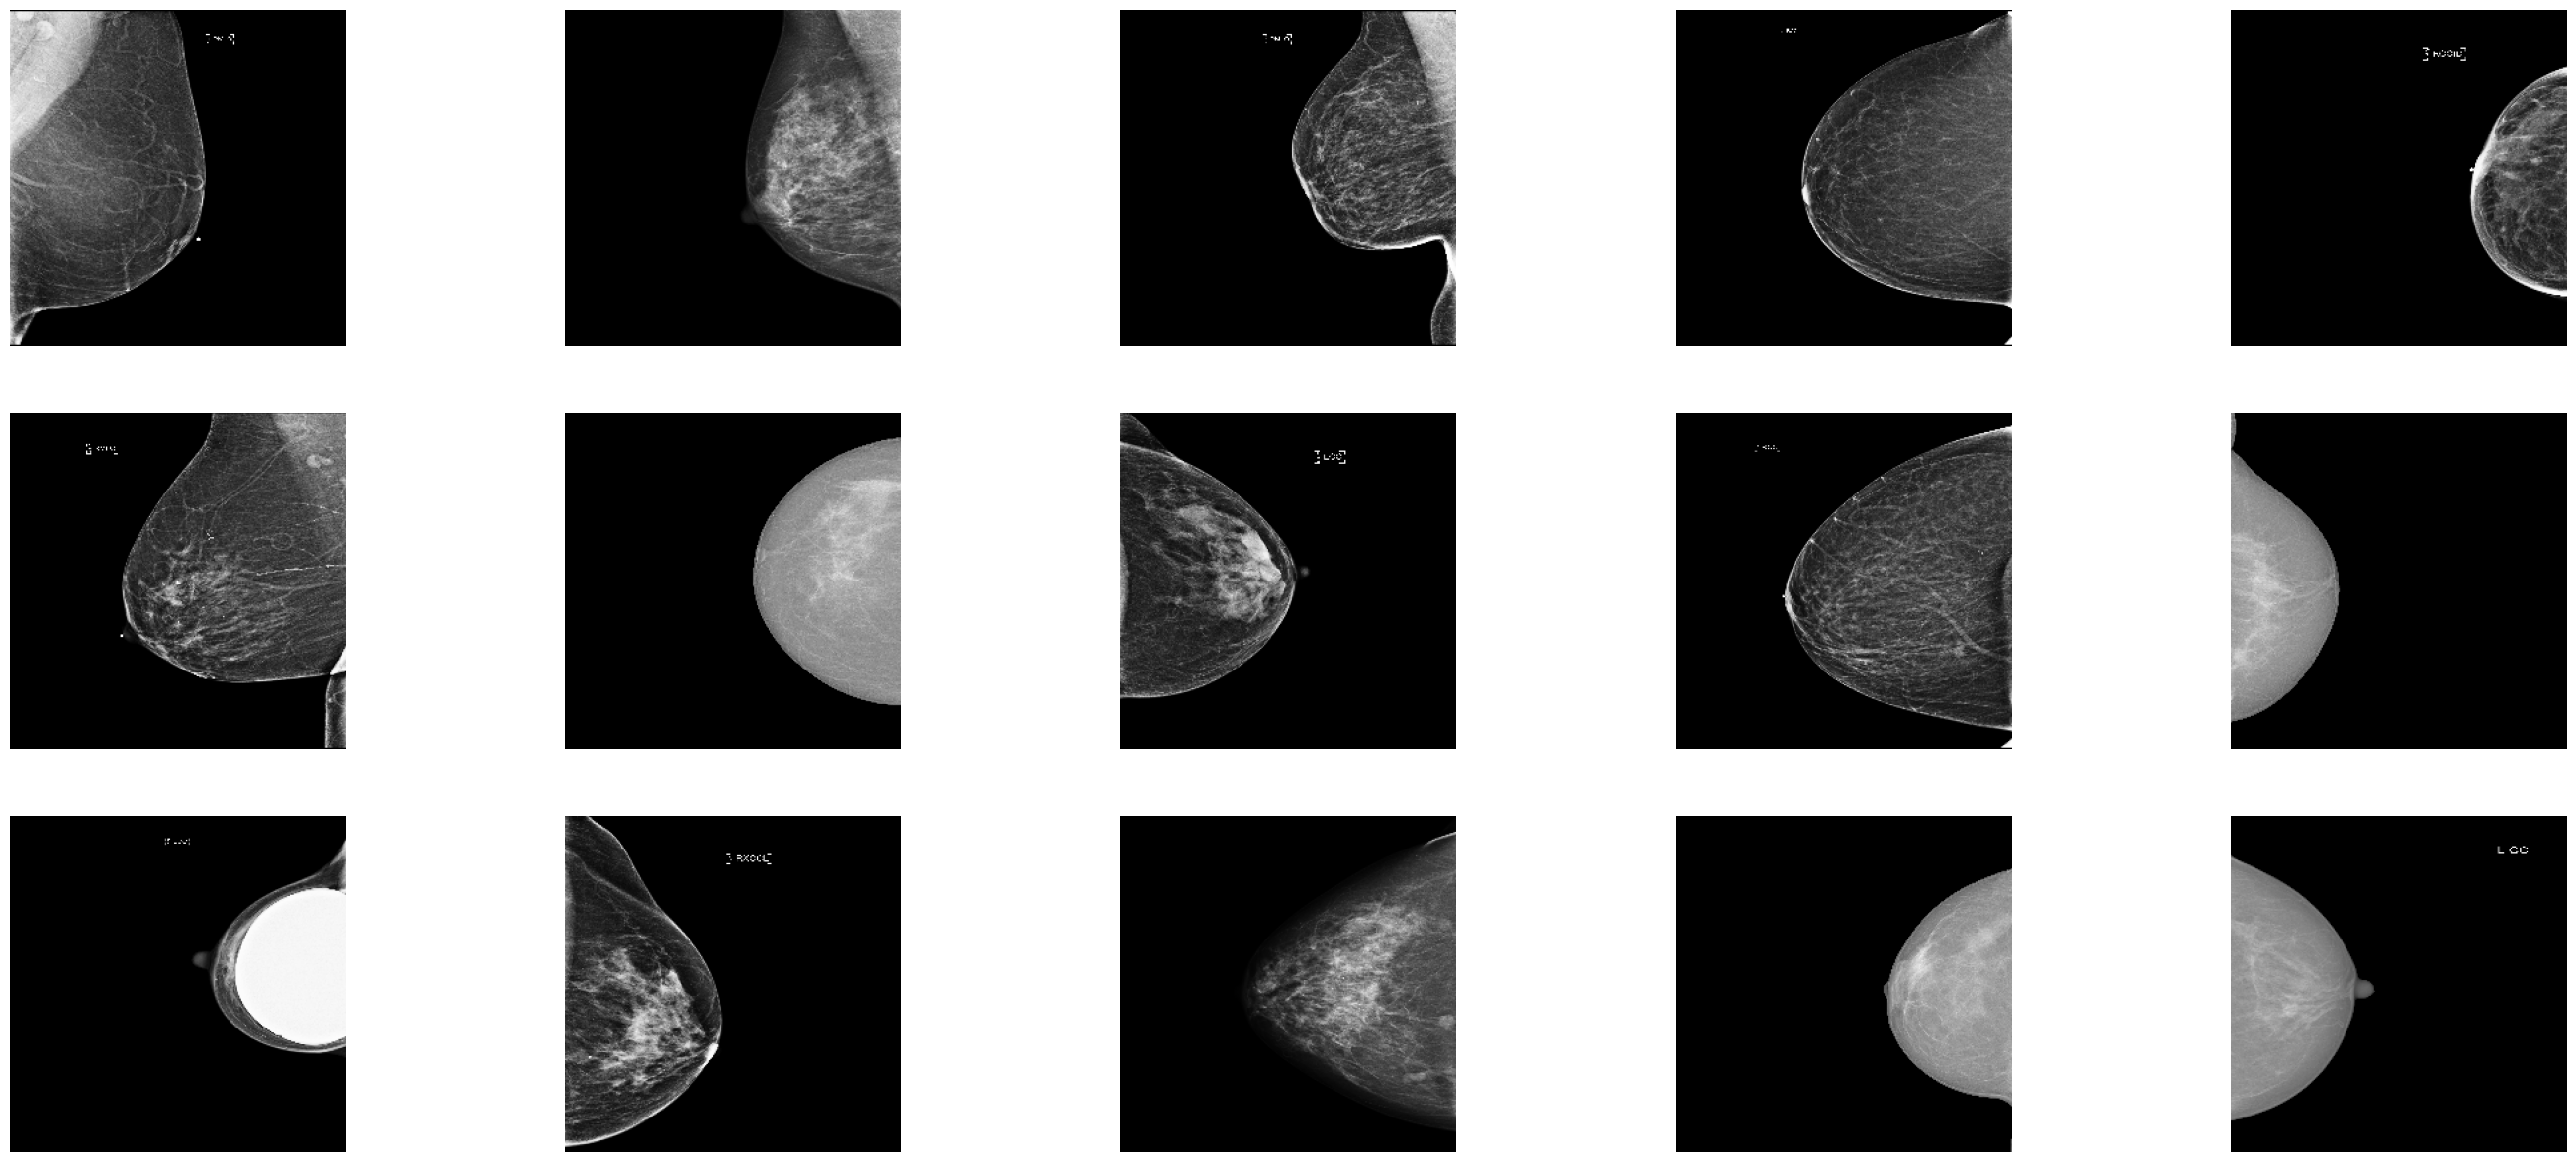

In [6]:
plot_images("new_test.csv")

## Handling data imbalance using downsampling

In [7]:
train_data = pd.read_csv("train.csv")
neg_cases = train_data[train_data["cancer"] == 0]
pos_cases  = train_data[train_data["cancer"] == 1]
print(neg_cases.shape)
print(pos_cases.shape)

(53548, 14)
(1158, 14)


In [8]:
from sklearn.utils import resample
neg_cases_dwn = resample(neg_cases,
             replace=True,
             n_samples=len(pos_cases),
             random_state=42)

print(neg_cases_dwn.shape)

(1158, 14)


In [9]:
down_sampled_data = pd.concat([neg_cases_dwn, pos_cases], ignore_index=True)
down_sampled_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,27099,564652979,R,CC,53.0,0,0,0,1.0,0,C,49,False
1,1,10925,1726416481,L,MLO,47.0,0,0,0,1.0,0,C,49,False
2,2,52006,2087336834,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
3,1,59152,1993388187,L,CC,51.0,0,0,0,NaN,0,C,49,False
4,1,22359,907140921,L,CC,63.0,0,0,0,1.0,0,C,93,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False
2312,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False
2313,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False
2314,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False


In [10]:
image_path = "C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA_SS/Cancer_de_Mama_IA_SS_2023/data/raw_images/"

# Auxiliary function for cnoncatenating the image path
def concat_img_path( patient_id, image_id, img_path = image_path):
    image_path = img_path + str(patient_id) + "_" + str(image_id) + ".png"
    return image_path

# This function will clean the data in order to contain only image path and label
def clean_data(data):
    new_data = data[['cancer']].copy()
    new_data.rename(columns={'cancer': "label"}, inplace=True)
    images_path = []
    for i in range(len(data)):
        image = concat_img_path(data["patient_id"][i], data["image_id"][i])
        images_path.append(image)
    
    new_data['images_path'] = images_path
    new_data = new_data[['images_path', 'label']]
    return new_data  

In [11]:
data_to_split = clean_data(down_sampled_data)
data_to_split = data_to_split.sample(frac = 1)
data_to_split.head(10)

,images_path,label
400,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
1708,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
1240,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
1649,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
1846,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
2034,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
742,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
896,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
43,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
1464,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1


So with the preprocessing above we achieve a balanced dataset, considering the purpose of this little experiment it´s okay. But in practice we should try to use all data available and try different methodologies like data augmentation or applying class weights 

In [13]:
print("The final dataset contains", len(data_to_split), "images")

The final dataset contains 2316 images


In [14]:
# Process for splitting the data
np.random.seed(10)
rnd = np.random.rand(len(data_to_split))
train = data_to_split[ rnd < 0.8  ]
test = data_to_split[ (rnd >= 0.8)]
print(len(data_to_split), len(train), len(test))

2316 1852 464


In [15]:
train.to_csv('new_train.csv', header=False, index=False)
test.to_csv('new_test.csv', header=False, index=False)

In [16]:
def _decode_csv(csv_row):
    record_defaults = ["path", "class"]
    try:
        filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
        img = read_and_decode(filename)
        label = tf.argmax(tf.math.equal(["0","1"], label_string))
    except:
        print('File corrupted')
    return img, label


train_dataset = (tf.data.TextLineDataset('new_train.csv').map(_decode_csv)).batch(32)
test_dataset = (tf.data.TextLineDataset('new_test.csv').map(_decode_csv)).batch(32)

In [17]:
train_dataset, test_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Looking to our datasets objects and checking it all looks fine, so we get two tensor one for the image and another one for the label.

In [21]:
labels = pd.read_csv("new_train.csv")
labels.head()

,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA_SS/Cancer_de_Mama_IA_SS_2023/data/raw_images/16754_1801566584.png,0
0,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
1,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
2,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
3,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
4,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1


In [22]:
# Calculating class weights to deal data imbalance

from sklearn.utils import compute_class_weight
train_labels = labels.loc[:, '0']
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(train_labels),
                                     y= train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 0.987726787620064, 1: 1.012582056892779}

In [37]:
# plotting utilities
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

### About the metrics 

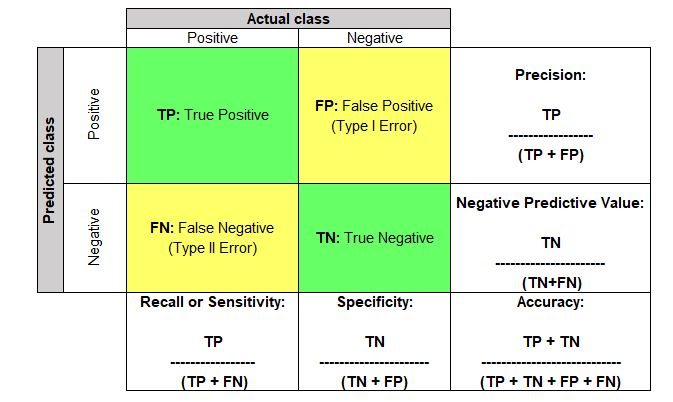

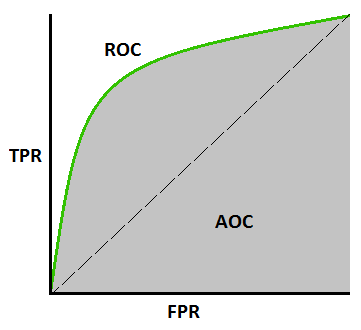

In [24]:
# custom metric
class pFBeta(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.cast(tf.reduce_sum(y_true), tf.float32)
        ctp = tf.cast(tf.reduce_sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.cast(tf.reduce_sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / (beta2 * prec + reca)

    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)

In [25]:
# build model
def build_model(num_hidden = 32, lrate=0.001, l1 = 0. ,
                 l2 = 0., num_classes=1):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                                   input_shape= (256, 256, 3),
                                                                   pooling= 'max')
    model = tf.keras.models.Sequential([
        base_model,
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')])
    return model

In [45]:
build_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_6 (Dense)             (None, 128)               196736    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,988,592
Trainable params: 10,901,289


In [26]:
model = build_model()

In [27]:
metrics = [pFBeta(beta=1, name='pF1'),
                   tfa.metrics.F1Score(num_classes=1, threshold=0.50, name='F1'),
                   tf.metrics.Precision(name='Prec'),
                   tf.metrics.Recall(name='Reca'),
                   tf.metrics.AUC(name='AUC'),
                   tf.metrics.BinaryAccuracy(name='BinAcc')]

In [28]:
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(momentum=0.9),
                loss= tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1), metrics= metrics)

In [29]:
history = model.fit(train_dataset, 
    epochs=4,
    batch_size=32,
    validation_data=test_dataset,
    class_weight=class_weights)

Epoch 1/4
58/58 [==============================] - 788s 13s/step - loss: 0.7461 - pF1: 0.6609 - F1: 0.6609 - Prec: 0.4935 - Reca: 1.0000 - AUC: 0.5000 - BinAcc: 0.4935 - val_loss: 0.6938 - val_pF1: 0.6893 - val_F1: 0.6893 - val_Prec: 0.5259 - val_Reca: 1.0000 - val_AUC: 0.5000 - val_BinAcc: 0.5259
Epoch 2/4
58/58 [==============================] - 715s 12s/step - loss: 0.7061 - pF1: 0.6609 - F1: 0.6609 - Prec: 0.4935 - Reca: 1.0000 - AUC: 0.5000 - BinAcc: 0.4935 - val_loss: 0.6955 - val_pF1: 0.6893 - val_F1: 0.6893 - val_Prec: 0.5259 - val_Reca: 1.0000 - val_AUC: 0.5000 - val_BinAcc: 0.5259
Epoch 3/4
58/58 [==============================] - 694s 12s/step - loss: 0.6943 - pF1: 0.6609 - F1: 0.6609 - Prec: 0.4935 - Reca: 1.0000 - AUC: 0.5000 - BinAcc: 0.4935 - val_loss: 0.6974 - val_pF1: 0.6893 - val_F1: 0.6893 - val_Prec: 0.5259 - val_Reca: 1.0000 - val_AUC: 0.5000 - val_BinAcc: 0.5259
Epoch 4/4
58/58 [==============================] - 695s 12s/step - loss: 0.6959 - pF1: 0.6609 - F1: 0.6

### Plotting the results of training

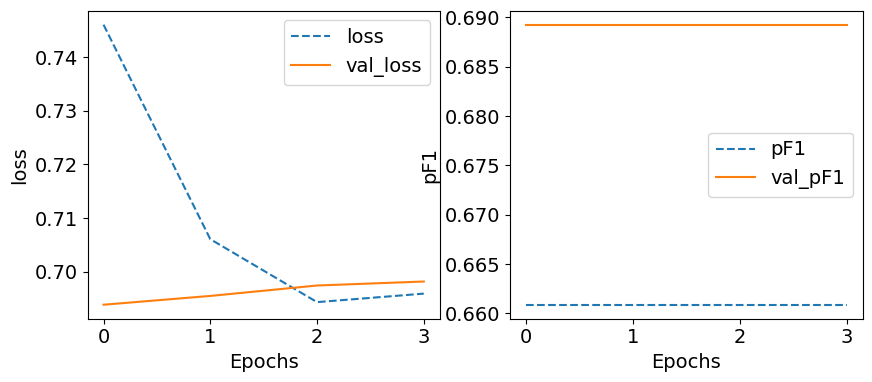

In [40]:
training_plot(['loss', 'pF1'], history)

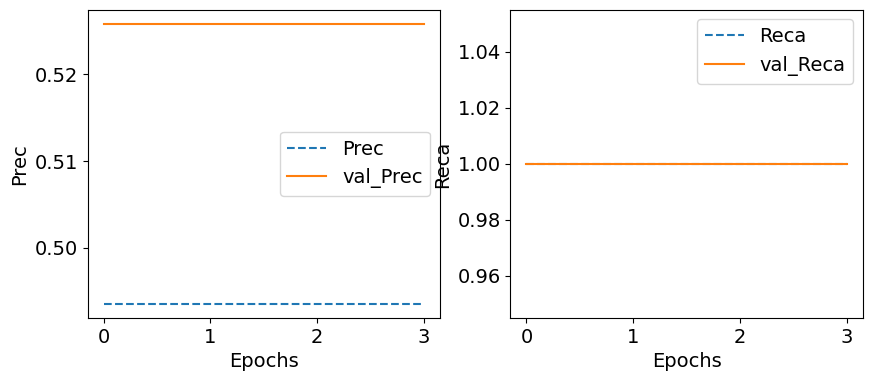

In [39]:
training_plot(['Prec', 'Reca'], history)

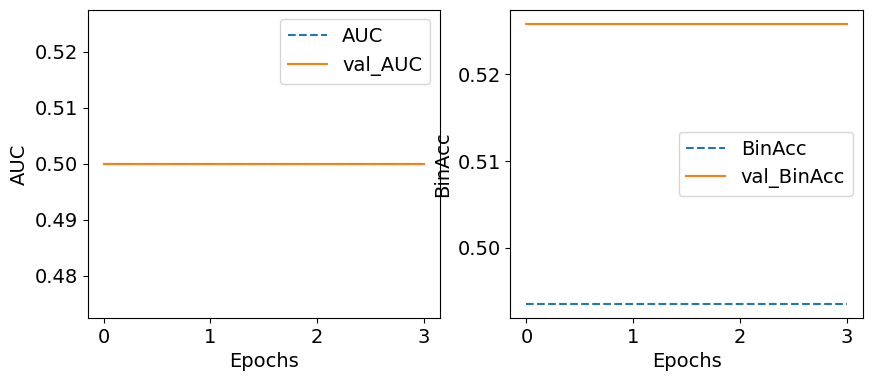

In [38]:
training_plot(['AUC', 'BinAcc'], history)

In [41]:
y_pred_proba = model.predict(test_dataset)

15/15 [==============================] - 35s 2s/step


In [49]:
y_pred_proba.shape

(464, 1)

**¡Important!**

If using the csv file remmeber that we drop the headers in the TensorFlow preprocessing part, so it would be good practice that after training load the file using column names. This specific time was for correctly plot the ROC and AUC from the experiment training.

In [58]:
labels_test = pd.read_csv("new_test.csv", names=["File_path", "Label"])
labels_test

,File_path,Label
0,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
1,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
2,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
3,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1
4,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
...,...,...
459,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
460,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
461,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
462,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,1


In [59]:
test_labels = labels_test.loc[:, 'Label']
test_labels

0      1
1      0
2      1
3      1
4      0
      ..
459    0
460    0
461    0
462    1
463    1
Name: Label, Length: 464, dtype: int64

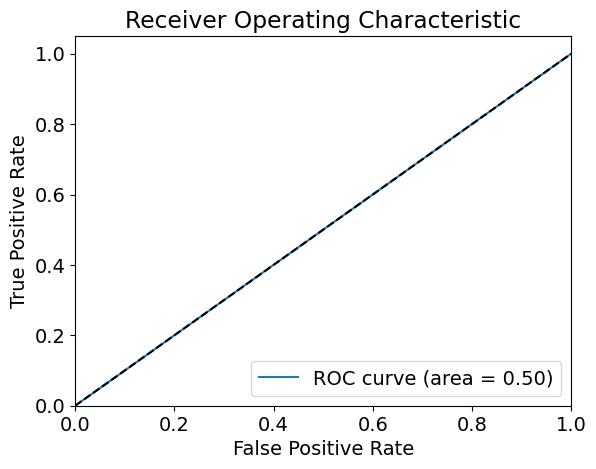

In [60]:
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()